In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2
from scipy.optimize import minimize

In [5]:
data_daily = pd.read_excel("C:\\Users\\salih\\Downloads\\EMF PROJ 2.xlsx", sheet_name="Daily")
data_daily = data_daily.rename(columns={np.nan: "Date"})
data_daily = data_daily.set_index('Date')
data_daily.index = pd.to_datetime(data_daily.index)
data_daily.dropna(inplace=True)

data_weekly = pd.read_excel("C:\\Users\\salih\\Downloads\\EMF PROJ 2.xlsx", sheet_name="Weekly")
data_weekly = data_weekly.rename(columns={np.nan: "Date"})
data_weekly = data_weekly.set_index('Date')
data_weekly.index = pd.to_datetime(data_weekly.index)
data_weekly.dropna(inplace=True)

sp500_weekly = data_weekly["S&P 500 COMPOSITE - PRICE INDEX"].copy()
nikkei_weekly = data_weekly["NIKKEI 225 STOCK AVERAGE - PRICE INDEX"].copy()
rf_annualized_weekly = data_weekly["US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE"].copy()
rf_weekly = np.exp(np.log(1 + rf_annualized_weekly/100) / 52) - 1
sp500_returns_weekly = sp500_weekly.pct_change().dropna()
nikkei_returns_weekly = nikkei_weekly.pct_change().dropna()

sp500_daily = data_daily["S&P 500 COMPOSITE - PRICE INDEX"].copy()
nikkei_daily = data_daily["NIKKEI 225 STOCK AVERAGE - PRICE INDEX"].copy()
rf_annualized_daily = data_daily["US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE"].copy()
rf_daily = np.exp(np.log(1 + rf_annualized_daily/100) / 252) - 1
sp500_returns_daily = sp500_daily.pct_change().dropna()
nikkei_returns_daily = nikkei_daily.pct_change().dropna()

display(data_weekly)
print(sp500_weekly)
print(rf_weekly)





,S&P 500 COMPOSITE - PRICE INDEX,NIKKEI 225 STOCK AVERAGE - PRICE INDEX,US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE
Date,,,
2001-01-01,1320.28,13785.69,6.6875
2001-01-08,1295.86,13867.61,5.8906
2001-01-15,1318.32,13506.23,6.0000
2001-01-22,1342.90,14032.42,5.9688
2001-01-29,1364.17,13845.28,6.0625
...,...,...,...
2023-11-27,4550.43,33447.67,5.3650
2023-12-04,4569.78,33231.27,5.3650
2023-12-11,4622.44,32791.80,5.3650


Date
2001-01-01    1320.28
2001-01-08    1295.86
2001-01-15    1318.32
2001-01-22    1342.90
2001-01-29    1364.17
               ...   
2023-11-27    4550.43
2023-12-04    4569.78
2023-12-11    4622.44
2023-12-18    4740.56
2023-12-25    4754.63
Name: S&P 500 COMPOSITE - PRICE INDEX, Length: 1200, dtype: float64
Date
2001-01-01    0.001246
2001-01-08    0.001101
2001-01-15    0.001121
2001-01-22    0.001116
2001-01-29    0.001133
                ...   
2023-11-27    0.001006
2023-12-04    0.001006
2023-12-11    0.001006
2023-12-18    0.001006
2023-12-25    0.001006
Name: US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE, Length: 1200, dtype: float64


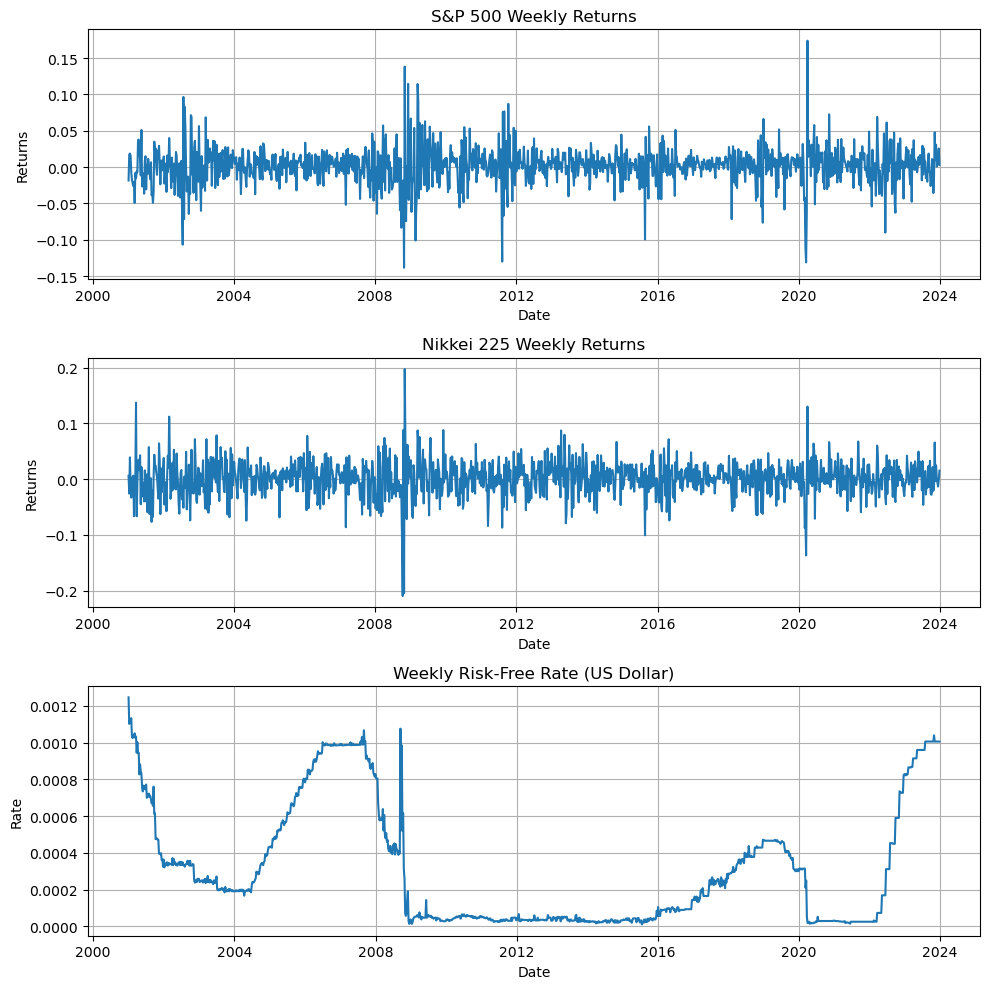

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(sp500_returns_weekly)
axs[0].set_title('S&P 500 Weekly Returns')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Returns')
axs[0].grid()

axs[1].plot(nikkei_returns_weekly)
axs[1].set_title('Nikkei 225 Weekly Returns')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Returns')
axs[1].grid()


axs[2].plot(rf_weekly)
axs[2].set_title('Weekly Risk-Free Rate (US Dollar)')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Rate')
axs[2].grid()

plt.tight_layout()
plt.show()

# 1) Static Allocation

In [7]:
def optimal_weights(asset_returns, bond_returns, lambd):

    asset_returns_mean = np.mean(asset_returns)
    bond_returns_mean = np.mean(bond_returns)
    mu = np.array([asset_returns_mean, bond_returns_mean])

    covariance_matrix = np.cov(asset_returns, bond_returns)
    inv_covmat = np.linalg.inv(covariance_matrix)
    a = (1/lambd) * inv_covmat @ (mu - rf_weekly.mean() * np.ones(2))
    weight_asset = a[0]
    weight_bond = a[1]

    weights_rf = 1 - np.sum(a)
    portfolio_risk = np.sqrt(a @ covariance_matrix @ a)
    portfolio_return = a @ mu + weights_rf * rf_weekly.mean()

    dataframe = pd.DataFrame([lambd, weight_asset, weight_bond, weights_rf, portfolio_risk, portfolio_return], index=["Risk Aversion","Weight in Asset", "Weight in Bond", "Weight in RF", "Portfolio Weekly Risk", "Portfolio Weekly Return"]).T

    return dataframe



In [8]:
risk2 = optimal_weights(sp500_returns_weekly, nikkei_returns_weekly, 2)
risk10 = optimal_weights(sp500_returns_weekly, nikkei_returns_weekly, 10)


display(risk2, risk10)

#Q1 et Q2 fini

,Risk Aversion,Weight in Asset,Weight in Bond,Weight in RF,Portfolio Weekly Risk,Portfolio Weekly Return
0,2.0,0.735905,0.11293,0.151165,0.021255,0.00122


,Risk Aversion,Weight in Asset,Weight in Bond,Weight in RF,Portfolio Weekly Risk,Portfolio Weekly Return
0,10.0,0.147181,0.022586,0.830233,0.004251,0.000497


# 2) Estimation of a GARCH model

In [9]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

def ks_stat(data, dist='norm'):
    sample_x, sample_y = ecdf(data)
    norm_y = norm.cdf(sample_x, np.mean(data), np.std(data))
    ks_statistic = np.max(np.abs(sample_y - norm_y))
    return ks_statistic


In [10]:
ks_critvalue_5pct = 1.36 * np.sqrt(1 / len(sp500_returns_weekly))
sp500_excess_returns = pd.Series(sp500_returns_weekly - rf_weekly).dropna()
nikkei_excess_returns = pd.Series(nikkei_returns_weekly - rf_weekly).dropna()
sp500_squared_excess_returns = sp500_excess_returns**2
nikkei_squared_excess_returns = nikkei_excess_returns**2

In [11]:
ks_results_df = pd.DataFrame(columns=['KS Statistic', 'Critical Value', 'Reject Null Hypothesis'])
ks_results_df.loc['S&P 500 Excess Returns'] = [ks_stat(sp500_excess_returns), ks_critvalue_5pct, ks_stat(sp500_excess_returns) > ks_critvalue_5pct]
ks_results_df.loc['Nikkei 225 Excess Returns'] = [ks_stat(nikkei_excess_returns), ks_critvalue_5pct, ks_stat(nikkei_excess_returns) > ks_critvalue_5pct]
ks_results_df.loc['S&P 500 Squared Excess Returns'] = [ks_stat(sp500_squared_excess_returns), ks_critvalue_5pct, ks_stat(sp500_squared_excess_returns) > ks_critvalue_5pct]
ks_results_df.loc['Nikkei 225 Squared Excess Returns'] = [ks_stat(nikkei_squared_excess_returns), ks_critvalue_5pct, ks_stat(nikkei_squared_excess_returns) > ks_critvalue_5pct]

ks_results_df

,KS Statistic,Critical Value,Reject Null Hypothesis
S&P 500 Excess Returns,0.082722,0.039276,True
Nikkei 225 Excess Returns,0.051201,0.039276,True
S&P 500 Squared Excess Returns,0.357923,0.039276,True
Nikkei 225 Squared Excess Returns,0.350044,0.039276,True


In [12]:
def ljungbox_test(errors_series, lags):
    results = []
    n = len(errors_series)
    Q = 0
    for lag in range (1, lags + 1):
        rho = np.corrcoef(errors_series[:-lag], errors_series[lag:])[0, 1]
        Q += (n * (n+2) * rho**2) / (n - lag)
        pvalue = (1 - chi2.cdf(Q, lags))
        results.append({'Lag': lag, 'Q-Stat': Q.round(4), 'P-Value': pvalue.round(4)})

    results_df = pd.DataFrame(results)
    results_df.set_index('Lag', inplace=True)
    return results_df

In [13]:
display(ljungbox_test(sp500_excess_returns, 4))

,Q-Stat,P-Value
Lag,,
1,6.9532,0.1384
2,6.9581,0.1381
3,7.5234,0.1107
4,8.1038,0.0878


In [14]:
display(ljungbox_test(nikkei_excess_returns, 4))

,Q-Stat,P-Value
Lag,,
1,7.2739,0.1221
2,7.7602,0.1008
3,8.6642,0.0701
4,9.6493,0.0468


In [15]:
display(ljungbox_test(sp500_squared_excess_returns, 4))

,Q-Stat,P-Value
Lag,,
1,148.5521,0.0
2,262.5456,0.0
3,344.4510,0.0
4,368.3562,0.0


In [16]:
display(ljungbox_test(nikkei_squared_excess_returns, 4))

,Q-Stat,P-Value
Lag,,
1,159.0329,0.0
2,317.1948,0.0
3,440.5558,0.0
4,458.6921,0.0


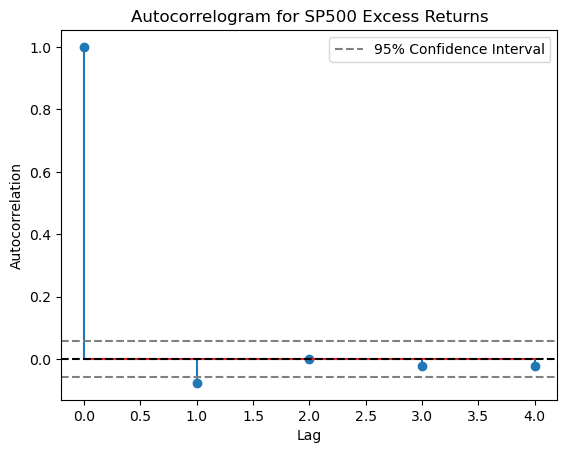

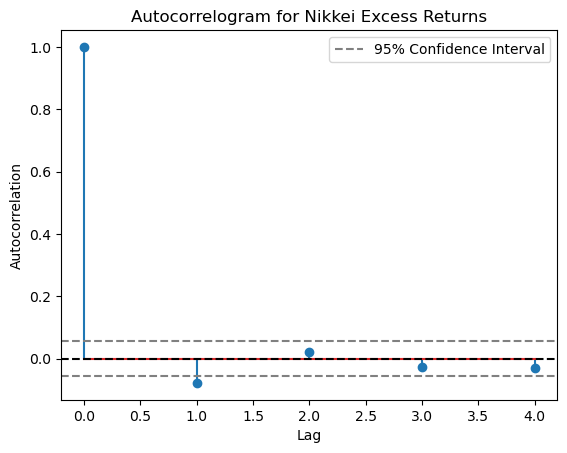

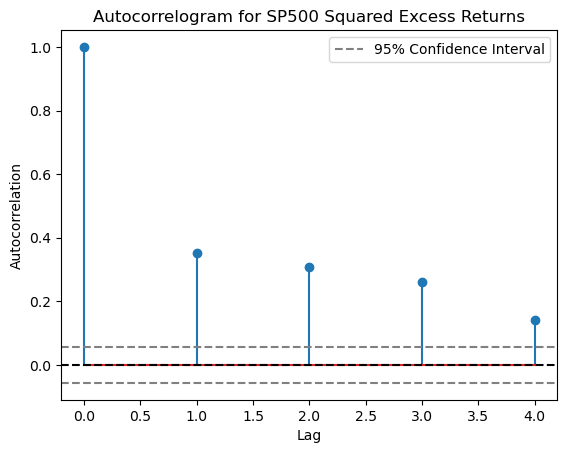

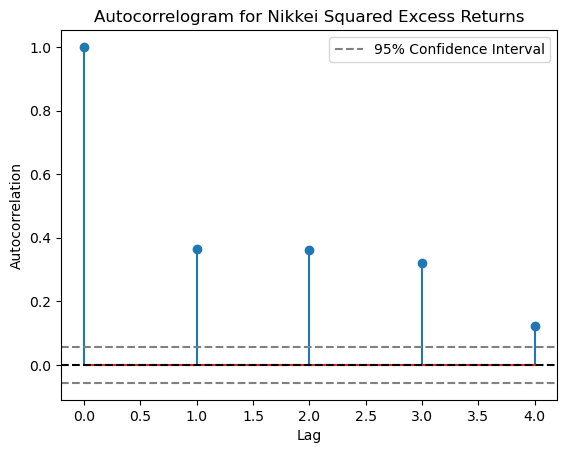

In [17]:
def autocorrelogram(errors_series, max_lag):
    n = len(errors_series)
    errors_mean = np.mean(errors_series)
    autocorrelation = np.array([1.0 if lag ==0 else np.corrcoef(errors_series[lag:], errors_series[:-lag])[0, 1] for lag in range(max_lag + 1)])
    return autocorrelation


data_series = {
    'SP500 Excess Returns': sp500_excess_returns,
    'Nikkei Excess Returns': nikkei_excess_returns,
    'SP500 Squared Excess Returns': sp500_squared_excess_returns,
    'Nikkei Squared Excess Returns': nikkei_squared_excess_returns
}

for title, series in data_series.items():
    autocorrelations = autocorrelogram(series, 4)
    lags = np.arange(len(autocorrelations))
    conf_interval = 1.96 / np.sqrt(len(series))

    plt.stem(lags, autocorrelations)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelogram for {title}')
    plt.axhline(0, linestyle='--', color='black')
    plt.axhline(conf_interval, linestyle='--', color='gray', label="95% Confidence Interval")
    plt.axhline(-conf_interval, linestyle='--', color='gray')
    plt.legend()
    plt.show()

In [18]:
def estimate_ar1(returns):

    lagged_returns = returns.shift(1)
    returns = returns.iloc[1:]
    
    lagged_returns.dropna(inplace=True)
    returns.dropna(inplace=True)

    X = lagged_returns.values
    Y = returns.values 

    X = np.column_stack((np.ones(len(X)), X))

    a, b = np.linalg.lstsq(X, Y, rcond=None)[0]

    predicted = X @ [a, b]

    residuals = Y - predicted
    SS_Residual = sum((Y - predicted)**2)
    SS_Total = sum((Y - np.mean(Y))**2)
    r_squared = 1 - (float(SS_Residual)) / SS_Total

    return a, b, r_squared, residuals

ar1_sp500_alpha, ar1_sp500_beta, ar1_sp500_rsquared, ar1_sp500_residuals = estimate_ar1(sp500_returns_weekly)
ar1_nikkei_alpha, ar1_nikkei_beta, ar1_nikkei_rsquared, ar1_nikkei_residuals = estimate_ar1(nikkei_returns_weekly)


In [19]:
def plot_ar1(residuals, a, b, r_squared, title):    
    estimation_df = pd.DataFrame({'AR(1) Estimation of :': title, 'α': [a], 'β': [b], 'R\u00B2': [r_squared]})

    display(estimation_df)
    plt.figure(figsize=(10, 5))
    plt.plot(residuals)
    plt.title('Residuals from AR(1) Model')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.show()


,AR(1) Estimation of :,α,β,R²
0,S&P 500,0.001527,-0.077179,0.00596


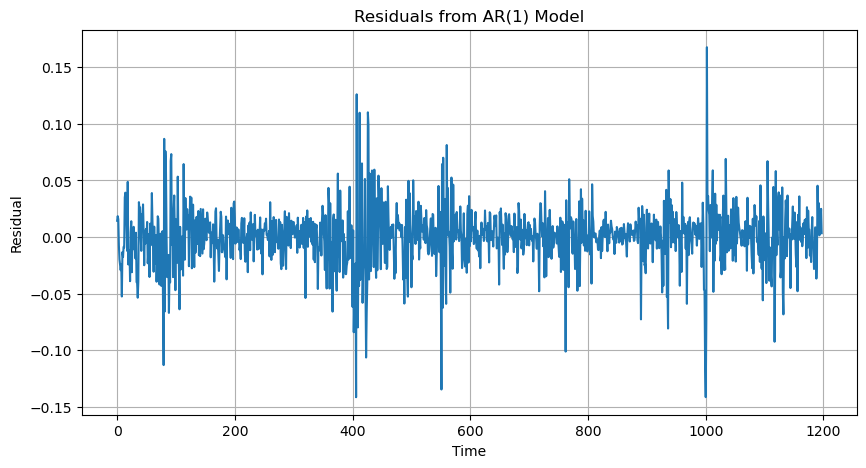

In [20]:
plot_ar1(ar1_sp500_residuals, ar1_sp500_alpha, ar1_sp500_beta, ar1_sp500_rsquared, 'S&P 500')

,AR(1) Estimation of :,α,β,R²
0,Nikkei 225,0.00133,-0.078683,0.00619


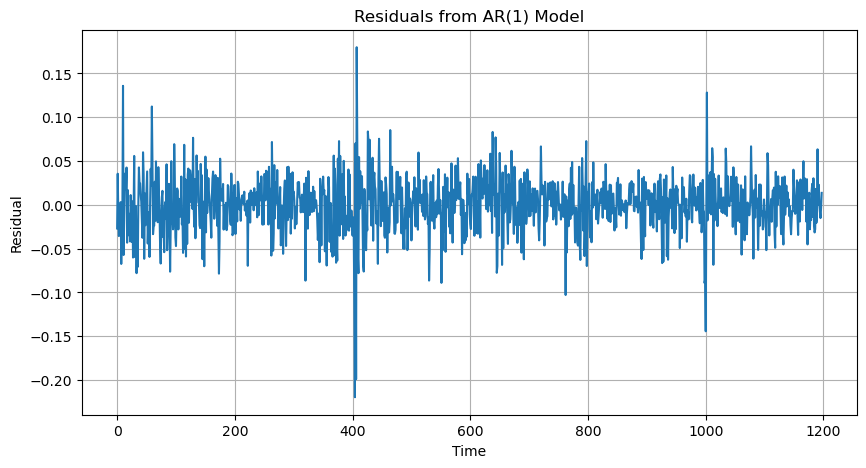

In [21]:
plot_ar1(ar1_nikkei_residuals, ar1_nikkei_alpha, ar1_nikkei_beta, ar1_nikkei_rsquared, 'Nikkei 225')

In [22]:
def garch_log_likelihood(params, data):
    alpha, beta, omega = params
    n = len(data)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(data)
    for t in range(1, n):
        sigma2[t] = omega + alpha * (data[t-1] ** 2) + beta * sigma2[t-1]

    sigma2 = np.where(sigma2 > 0, sigma2, 1e-8)
    ll = -0.5 * np.sum(np.log(2 * np.pi * sigma2) + (data ** 2) / sigma2)
    return -ll 

def fit_garch(data, initial_params):
    bounds = [(0, 1), (0, 1), (1e-8, None)] 

    result = minimize(garch_log_likelihood, initial_params, args=(data),
                      bounds=bounds, method='L-BFGS-B')
    return result.x
    

def garch_df(results, title):
    alpha_est, beta_est, omega_est = results
    return pd.DataFrame({'GARCH(1,1) Model of :': title, 'α': [alpha_est], 'β': [beta_est], 'ω': [omega_est], 'α + β': [alpha_est + beta_est]})
    

In [23]:
garch_sp500_results = fit_garch(ar1_sp500_residuals, [0.1, 0.1, 1e-6])
garch_df(garch_sp500_results, 'S&P 500')

,"GARCH(1,1) Model of :",α,β,ω,α + β
0,S&P 500,0.231418,0.730049,0.000033,0.961467


In [24]:
garch_nikkei_results = fit_garch(ar1_nikkei_residuals, [0.1, 0.8, 1e-6])
garch_df(garch_nikkei_results, 'Nikkei 225')


,"GARCH(1,1) Model of :",α,β,ω,α + β
0,Nikkei 225,0.1,0.799999,0.00009,0.899999


In [25]:
# POUR LES STD ERRORS ICI 

from arch import arch_model

def garch(title, series):
    garch_model = arch_model(series, mean="Zero", vol="Garch", rescale="False", p=1, q=1)
    garch_result = garch_model.fit(disp="off")

    alpha_garch = garch_result.params['alpha[1]']
    beta_garch = garch_result.params['beta[1]']
    omega_garch = garch_result.params['omega']
    
    garch_results_df = pd.DataFrame({'GARCH(1,1) Model of :': title, 'α': [alpha_garch], 'β': [beta_garch], 'ω': [omega_garch], 'α + β': [alpha_garch + beta_garch]})

    return garch_result, garch_results_df

In [26]:
garch_stats_sp500, garch_stats_df_sp500 = garch('S&P 500', ar1_sp500_residuals)

print(garch_stats_sp500)
display(garch_stats_df_sp500)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2902.10
Distribution:                  Normal   AIC:                          -5798.20
Method:            Maximum Likelihood   BIC:                          -5782.94
                                        No. Observations:                 1198
Date:                Mon, May 13 2024   Df Residuals:                     1198
Time:                        19:21:49   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2628e-05  4.219e-06      7.734  1.039e-14 [2.

,"GARCH(1,1) Model of :",α,β,ω,α + β
0,S&P 500,0.231419,0.729972,0.000033,0.96139


In [27]:
garch_stats_nikkei, garch_stats_df_nikkei = garch('NIKKEI 225', ar1_nikkei_residuals)

print(garch_stats_sp500)
display(garch_stats_df_sp500)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2902.10
Distribution:                  Normal   AIC:                          -5798.20
Method:            Maximum Likelihood   BIC:                          -5782.94
                                        No. Observations:                 1198
Date:                Mon, May 13 2024   Df Residuals:                     1198
Time:                        19:21:49   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2628e-05  4.219e-06      7.734  1.039e-14 [2.

,"GARCH(1,1) Model of :",α,β,ω,α + β
0,S&P 500,0.231419,0.729972,0.000033,0.96139


In [28]:
import scipy.stats

crit_value_chi2 = scipy.stats.chi2.ppf(0.95, 1)

theta_est_nikkei = garch_stats_nikkei.params['alpha[1]'] + garch_stats_nikkei.params['beta[1]']
theta_se_nikkei = np.sqrt(garch_stats_nikkei.std_err['alpha[1]'] **2 + garch_stats_nikkei.std_err['beta[1]'] **2)
test_statistic_nikkei = (theta_est_nikkei - 1)**2 / (theta_se_nikkei)**2

theta_est_sp = garch_stats_sp500.params['alpha[1]'] + garch_stats_sp500.params['beta[1]']
theta_se_sp = np.sqrt(garch_stats_sp500.std_err['alpha[1]'] **2 + garch_stats_sp500.std_err['beta[1]'] **2)
test_statistic_sp = (theta_est_sp - 1)**2 / (theta_se_sp)**2

display(pd.DataFrame({'SP500 : α + β < 1': [theta_est_sp, theta_se_sp, test_statistic_sp, crit_value_chi2, test_statistic_sp > crit_value_chi2], 'Nikkei 225 : α + β < 1': [theta_est_nikkei, theta_se_nikkei, test_statistic_nikkei, crit_value_chi2, test_statistic_nikkei > crit_value_chi2]}, index=['Estimation', 'Standard Error', 'Test Statistic', 'Critical Value', 'Reject Null Hypothesis']))


,SP500 : α + β < 1,Nikkei 225 : α + β < 1
Estimation,0.96139,0.9
Standard Error,0.050337,0.083887
Test Statistic,0.588314,1.421057
Critical Value,3.841459,3.841459
Reject Null Hypothesis,False,False


In [29]:
def mu_var(returns, ar_alpha, ar_beta, ar_residuals, garch_omega, garch_alpha, garch_beta, stock_bond):
    n = len(returns)
    mu = np.zeros(n)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(ar_residuals, ddof=1) # Vu que les résidus n'ont pas d'autocorrelation on peut initialiser avec eux

    for t in range(1, n):
        mu[t] = ar_alpha + ar_beta * returns[t-1]  # Expected return for t+1
        sigma2[t] = garch_omega + garch_alpha * ar_residuals[t-1]**2 + garch_beta * sigma2[t-1]  # Variance for t+1

    test_data = pd.DataFrame({f'{stock_bond} Returns': returns, f'{stock_bond} Expected Returns': mu, f'{stock_bond} Expected Variance': sigma2})

    return test_data


,Stock Returns,Stock Expected Returns,Stock Expected Variance
Date,,,
2001-01-08,-0.018496,0.000000,0.000662
2001-01-15,0.017332,0.002955,0.000564
2001-01-22,0.018645,0.000190,0.000523
2001-01-29,0.015839,0.000088,0.000472
2001-02-05,-0.007228,0.000305,0.000390
...,...,...,...
2023-11-27,0.000671,-0.000849,0.000585
2023-12-04,0.004252,0.001476,0.000462
2023-12-11,0.011524,0.001199,0.000394


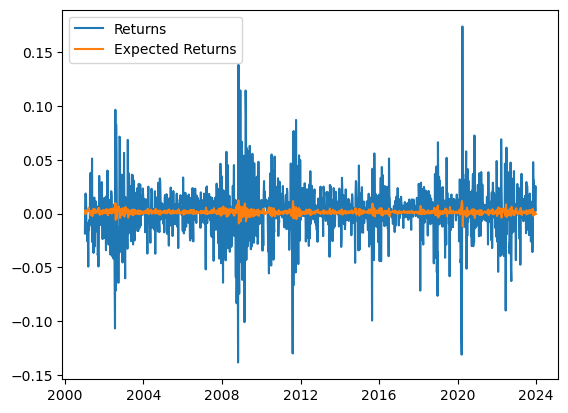

In [30]:
mu_var_stocks = mu_var(sp500_returns_weekly, ar1_sp500_alpha, ar1_sp500_beta, ar1_sp500_residuals, garch_stats_sp500.params['omega'], garch_stats_sp500.params['alpha[1]'], garch_stats_sp500.params['beta[1]'], "Stock")
display(mu_var_stocks)

plt.plot(mu_var_stocks["Stock Returns"], label = "Returns")
plt.plot(mu_var_stocks["Stock Expected Returns"], label = "Expected Returns")
plt.legend()
plt.show()

,Bond Returns,Bond Expected Returns,Bond Expected Variance
Date,,,
2001-01-08,0.005942,0.000000,0.000990
2001-01-15,-0.026059,0.000862,0.000964
2001-01-22,0.038959,0.003380,0.000997
2001-01-29,-0.013336,-0.001735,0.000910
2001-02-05,-0.033207,0.002379,0.000953
...,...,...,...
2023-11-27,0.001786,-0.000609,0.000840
2023-12-04,-0.006470,0.001189,0.000777
2023-12-11,-0.013225,0.001839,0.000743


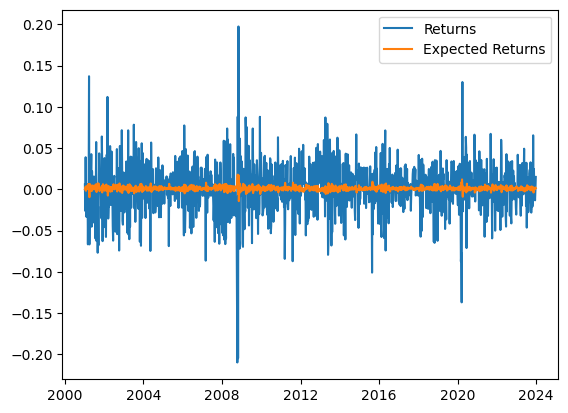

In [31]:
mu_var_bonds = mu_var(nikkei_returns_weekly, ar1_nikkei_alpha, ar1_nikkei_beta, ar1_nikkei_residuals, garch_stats_nikkei.params['omega'], garch_stats_nikkei.params['alpha[1]'], garch_stats_nikkei.params['beta[1]'], "Bond")
display(mu_var_bonds)

plt.plot(mu_var_bonds["Bond Returns"], label = "Returns")
plt.plot(mu_var_bonds["Bond Expected Returns"], label = "Expected Returns")
plt.legend()
plt.show()

In [32]:
T = len(mu_var_stocks)
rho_sb = np.corrcoef(ar1_sp500_residuals, ar1_nikkei_residuals)[0, 1]

covariance_matrices = np.zeros((T, 2, 2))

for t in range(1, T):
    variance_stock = mu_var_stocks['Stock Expected Variance'].iloc[t]
    variance_bond = mu_var_bonds['Bond Expected Variance'].iloc[t]

    covariance = rho_sb * np.sqrt(variance_stock) * np.sqrt(variance_bond)
    covariance_matrices[t] = [
        [variance_stock, covariance],
        [covariance, variance_bond]
    ]

covariance_matrices_df = pd.DataFrame(covariance_matrices.reshape(T, 4), index=mu_var_stocks.index, columns=pd.MultiIndex.from_product([['Stock', 'Bond'], ['Expected Variance', 'Covariance']]))
print(covariance_matrices_df.head())
print(covariance_matrices)

dataframe_optimisation = mu_var_stocks.join(mu_var_bonds)
dataframe_optimisation["Covariance"] = covariance_matrices_df["Bond"]["Covariance"]
dataframe_optimisation = dataframe_optimisation.iloc[1:]
dataframe_optimisation["Stock Return"] = sp500_returns_weekly
dataframe_optimisation["Bond Return"] = nikkei_returns_weekly
dataframe_optimisation["Weekly Risk Free"] = rf_weekly
dataframe_optimisation["Daily Stock Return"] = sp500_returns_daily
dataframe_optimisation["Daily Bond Return"] = nikkei_returns_daily
dataframe_optimisation["Daily Risk Free"] = rf_daily
dataframe_optimisation["Static Risk 2 Asset Weight"] = risk2["Weight in Asset"][0]
dataframe_optimisation["Static Risk 2 Bond Weight"] = risk2["Weight in Bond"][0]
dataframe_optimisation["Static Risk 2 RF Weight"] = risk2["Weight in RF"][0]
dataframe_optimisation["Static Risk 10 Asset Weight"] = risk10["Weight in Asset"][0]
dataframe_optimisation["Static Risk 10 Bond Weight"] = risk10["Weight in Bond"][0]
dataframe_optimisation["Static Risk 10 RF Weight"] = risk10["Weight in RF"][0]

display(dataframe_optimisation)

                       Stock                         Bond           
           Expected Variance Covariance Expected Variance Covariance
Date                                                                
2001-01-08          0.000000   0.000000          0.000000   0.000000
2001-01-15          0.000564   0.000436          0.000436   0.000964
2001-01-22          0.000523   0.000427          0.000427   0.000997
2001-01-29          0.000472   0.000387          0.000387   0.000910
2001-02-05          0.000390   0.000360          0.000360   0.000953
[[[0.         0.        ]
  [0.         0.        ]]

 [[0.00056357 0.00043565]
  [0.00043565 0.00096381]]

 [[0.00052283 0.00042669]
  [0.00042669 0.0009966 ]]

 ...

 [[0.00039431 0.00031997]
  [0.00031997 0.00074308]]

 [[0.00046413 0.00033562]
  [0.00033562 0.00069457]]

 [[0.00037412 0.0002967 ]
  [0.0002967  0.00067339]]]


,Stock Returns,Stock Expected Returns,Stock Expected Variance,Bond Returns,Bond Expected Returns,Bond Expected Variance,Covariance,Stock Return,Bond Return,Weekly Risk Free,Daily Stock Return,Daily Bond Return,Daily Risk Free,Static Risk 2 Asset Weight,Static Risk 2 Bond Weight,Static Risk 2 RF Weight,Static Risk 10 Asset Weight,Static Risk 10 Bond Weight,Static Risk 10 RF Weight
Date,,,,,,,,,,,,,,,,,,,
2001-01-15,0.017332,0.002955,0.000564,-0.026059,0.000862,0.000964,0.000964,0.017332,-0.026059,0.001121,0.000000,0.011874,0.000231,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-01-22,0.018645,0.000190,0.000523,0.038959,0.003380,0.000997,0.000997,0.018645,0.038959,0.001116,0.000268,0.003095,0.000230,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-01-29,0.015839,0.000088,0.000472,-0.013336,-0.001735,0.000910,0.000910,0.015839,-0.013336,0.001133,0.006805,0.010895,0.000234,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-02-05,-0.007228,0.000305,0.000390,-0.033207,0.002379,0.000953,0.000953,-0.007228,-0.033207,0.001030,0.003587,-0.023214,0.000212,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-02-12,-0.017721,0.002085,0.000408,0.002787,0.003943,0.000862,0.000862,-0.017721,0.002787,0.001024,0.011827,0.000000,0.000211,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,0.000671,-0.000849,0.000585,0.001786,-0.000609,0.000840,0.000840,0.000671,0.001786,0.001006,-0.001954,-0.005289,0.000207,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2023-12-04,0.004252,0.001476,0.000462,-0.006470,0.001189,0.000777,0.000777,0.004252,-0.006470,0.001006,-0.005408,-0.005990,0.000207,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2023-12-11,0.011524,0.001199,0.000394,-0.013225,0.001839,0.000743,0.000743,0.011524,-0.013225,0.001006,0.003925,0.014979,0.000207,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233


In [33]:
def dynamic_optimisation(lambd):
    n = len(dataframe_optimisation)
    weights = []
    for t in range(0, n):
        
        inv_cov = np.linalg.inv(covariance_matrices[t+1])
        mu = np.array([dataframe_optimisation['Stock Expected Returns'].iloc[t], dataframe_optimisation['Bond Expected Returns'].iloc[t]])
        e = np.ones(2)
        a = 1/lambd * inv_cov @ (mu - e*dataframe_optimisation["Weekly Risk Free"].iloc[t])
        weights.append(a)
    weights_array = np.array(weights)

    return weights_array

dataframe_optimisation["Dynamic Risk 2 Asset Weight"] = dynamic_optimisation(2)[:, 0]
dataframe_optimisation["Dynamic Risk 2 Bond Weight"] = dynamic_optimisation(2)[:, 1]
dataframe_optimisation["Dynamic Risk 2 RF Weight"] = 1 - np.sum(dynamic_optimisation(2), axis=1)

dataframe_optimisation["Dynamic Risk 10 Asset Weight"] = dynamic_optimisation(10)[:, 0]
dataframe_optimisation["Dynamic Risk 10 Bond Weight"] = dynamic_optimisation(10)[:, 1]
dataframe_optimisation["Dynamic Risk 10 RF Weight"] = 1 - np.sum(dynamic_optimisation(10), axis=1)

display(dataframe_optimisation)


,Stock Returns,Stock Expected Returns,Stock Expected Variance,Bond Returns,Bond Expected Returns,Bond Expected Variance,Covariance,Stock Return,Bond Return,Weekly Risk Free,...,Static Risk 2 RF Weight,Static Risk 10 Asset Weight,Static Risk 10 Bond Weight,Static Risk 10 RF Weight,Dynamic Risk 2 Asset Weight,Dynamic Risk 2 Bond Weight,Dynamic Risk 2 RF Weight,Dynamic Risk 10 Asset Weight,Dynamic Risk 10 Bond Weight,Dynamic Risk 10 RF Weight
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-15,0.017332,0.002955,0.000564,-0.026059,0.000862,0.000964,0.000964,0.017332,-0.026059,0.001121,...,0.151165,0.147181,0.022586,0.830233,2.660260,-1.336685,-0.323575,0.532052,-0.267337,0.735285
2001-01-22,0.018645,0.000190,0.000523,0.038959,0.003380,0.000997,0.000997,0.018645,0.038959,0.001116,...,0.151165,0.147181,0.022586,0.830233,-2.786210,2.329248,1.456962,-0.557242,0.465850,1.091392
2001-01-29,0.015839,0.000088,0.000472,-0.013336,-0.001735,0.000910,0.000910,0.015839,-0.013336,0.001133,...,0.151165,0.147181,0.022586,0.830233,0.287886,-1.698844,2.410958,0.057577,-0.339769,1.282192
2001-02-05,-0.007228,0.000305,0.000390,-0.033207,0.002379,0.000953,0.000953,-0.007228,-0.033207,0.001030,...,0.151165,0.147181,0.022586,0.830233,-2.433718,1.627823,1.805895,-0.486744,0.325565,1.161179
2001-02-12,-0.017721,0.002085,0.000408,0.002787,0.003943,0.000862,0.000862,-0.017721,0.002787,0.001024,...,0.151165,0.147181,0.022586,0.830233,-0.237955,1.790023,-0.552067,-0.047591,0.358005,0.689587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,0.000671,-0.000849,0.000585,0.001786,-0.000609,0.000840,0.000840,0.000671,0.001786,0.001006,...,0.151165,0.147181,0.022586,0.830233,-1.388831,-0.275627,2.664457,-0.277766,-0.055125,1.332891
2023-12-04,0.004252,0.001476,0.000462,-0.006470,0.001189,0.000777,0.000777,0.004252,-0.006470,0.001006,...,0.151165,0.147181,0.022586,0.830233,0.643161,-0.174685,0.531525,0.128632,-0.034937,0.906305
2023-12-11,0.011524,0.001199,0.000394,-0.013225,0.001839,0.000743,0.000743,0.011524,-0.013225,0.001006,...,0.151165,0.147181,0.022586,0.830233,-0.321913,0.699510,0.622404,-0.064383,0.139902,0.924481


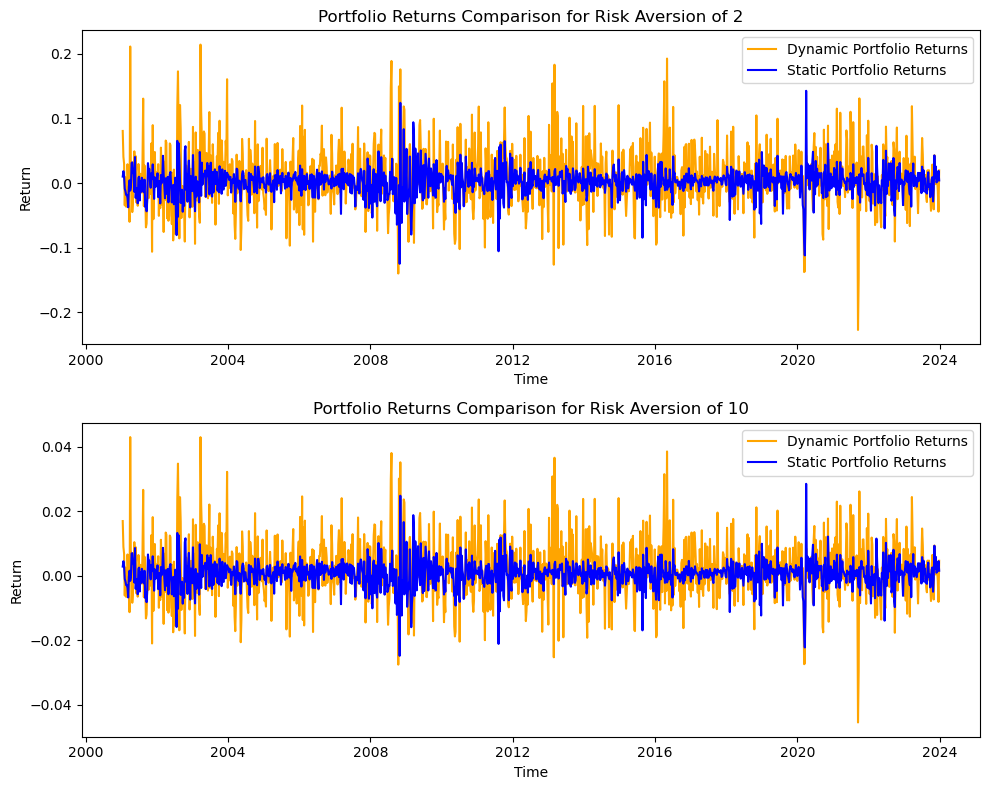

In [34]:
portfolios = pd.DataFrame(columns=["Dynamic Portfolio Return Risk 2", "Dynamic Portfolio Return Risk 10", "Static Portfolio Returns Risk 2", "Static Portfolio Returns Risk 10"])
portfolios["Dynamic Portfolio Return Risk 2"] = dataframe_optimisation["Dynamic Risk 2 Asset Weight"] * dataframe_optimisation["Stock Return"] + dataframe_optimisation["Dynamic Risk 2 Bond Weight"] * dataframe_optimisation["Bond Return"] + dataframe_optimisation["Dynamic Risk 2 RF Weight"] * dataframe_optimisation["Weekly Risk Free"]
portfolios["Dynamic Portfolio Return Risk 10"] = dataframe_optimisation["Dynamic Risk 10 Asset Weight"] * dataframe_optimisation["Stock Return"] + dataframe_optimisation["Dynamic Risk 10 Bond Weight"] * dataframe_optimisation["Bond Return"] + dataframe_optimisation["Dynamic Risk 10 RF Weight"] * dataframe_optimisation["Weekly Risk Free"]
portfolios["Static Portfolio Returns Risk 2"] = dataframe_optimisation["Static Risk 2 Asset Weight"] * dataframe_optimisation["Stock Return"] + dataframe_optimisation["Static Risk 2 Bond Weight"] * dataframe_optimisation["Bond Return"] + dataframe_optimisation["Static Risk 2 RF Weight"] * dataframe_optimisation["Weekly Risk Free"]
portfolios["Static Portfolio Returns Risk 10"] = dataframe_optimisation["Static Risk 10 Asset Weight"] * dataframe_optimisation["Stock Return"] + dataframe_optimisation["Static Risk 10 Bond Weight"] * dataframe_optimisation["Bond Return"] + dataframe_optimisation["Static Risk 10 RF Weight"] * dataframe_optimisation["Weekly Risk Free"]

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(portfolios["Dynamic Portfolio Return Risk 2"], label="Dynamic Portfolio Returns", c = 'orange')
ax[0].plot(portfolios["Static Portfolio Returns Risk 2"], label="Static Portfolio Returns", c = 'blue')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Return")
ax[0].legend()
ax[0].set_title("Portfolio Returns Comparison for Risk Aversion of 2")

ax[1].plot(portfolios["Dynamic Portfolio Return Risk 10"], label="Dynamic Portfolio Returns", c = 'orange')
ax[1].plot(portfolios["Static Portfolio Returns Risk 10"], label="Static Portfolio Returns", c = 'blue')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Return")
ax[1].legend()
ax[1].set_title("Portfolio Returns Comparison for Risk Aversion of 10")

plt.tight_layout()
plt.show()

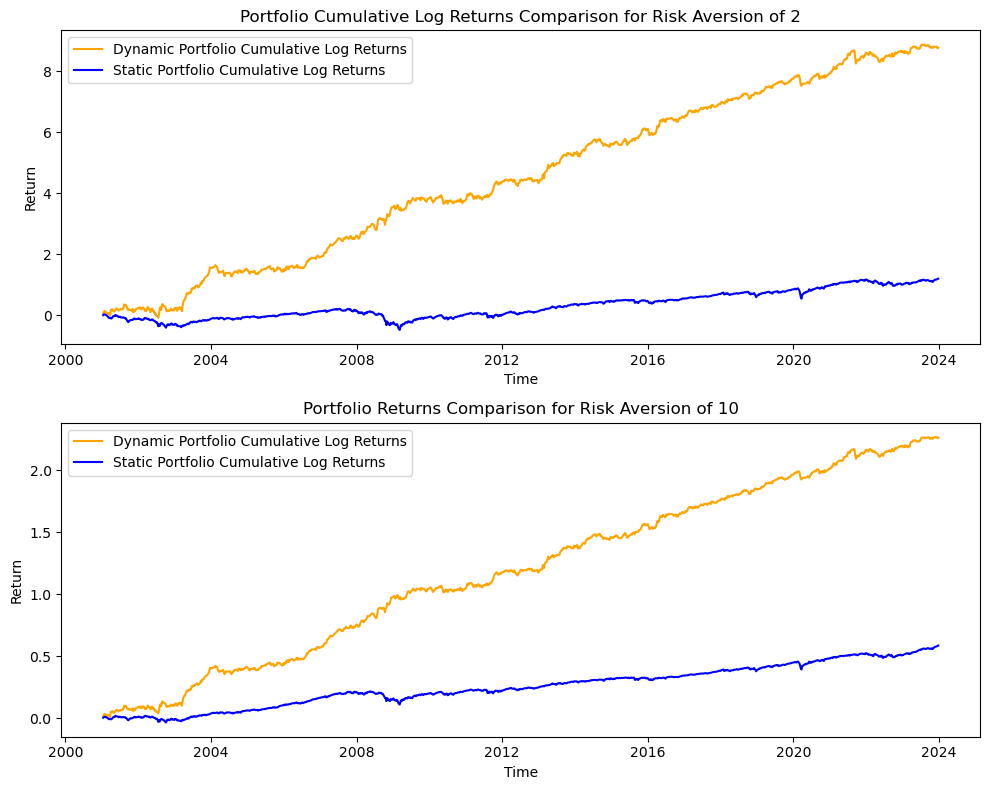

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(np.log(1 + portfolios["Dynamic Portfolio Return Risk 2"]).cumsum(), label="Dynamic Portfolio Cumulative Log Returns", c = 'orange')
ax[0].plot(np.log(1 + portfolios["Static Portfolio Returns Risk 2"]).cumsum(), label="Static Portfolio Cumulative Log Returns", c = 'blue')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Return")
ax[0].legend()
ax[0].set_title("Portfolio Cumulative Log Returns Comparison for Risk Aversion of 2")

ax[1].plot(np.log(1 + portfolios["Dynamic Portfolio Return Risk 10"]).cumsum(), label="Dynamic Portfolio Cumulative Log Returns", c = 'orange')
ax[1].plot(np.log(1 + portfolios["Static Portfolio Returns Risk 10"]).cumsum(), label="Static Portfolio Cumulative Log Returns", c = 'blue')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Return")
ax[1].legend()
ax[1].set_title("Portfolio Returns Comparison for Risk Aversion of 10")

plt.tight_layout()
plt.show()

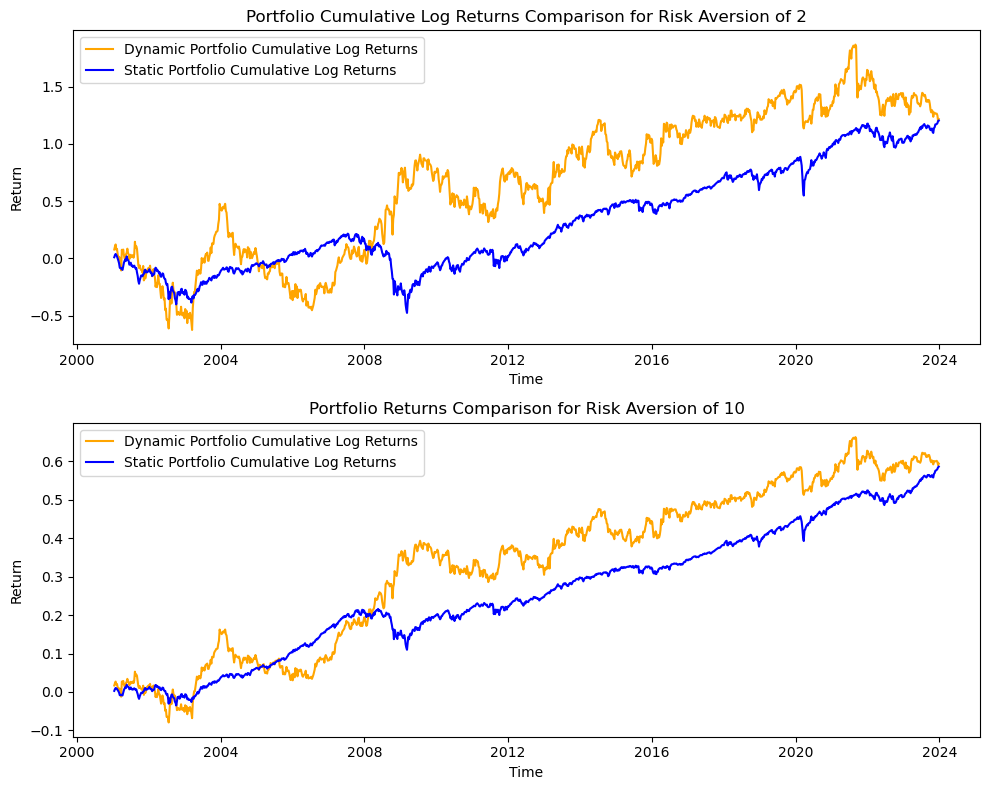

Date
2001-01-15    1318.32
2001-01-16    1326.65
2001-01-17    1329.47
2001-01-18    1347.97
2001-01-19    1342.54
               ...   
2023-12-25    4754.63
2023-12-26    4774.75
2023-12-27    4781.58
2023-12-28    4783.35
2023-12-29    4769.83
Name: S&P 500 COMPOSITE - PRICE INDEX, Length: 5990, dtype: float64


In [36]:
dataframe_optimisation['Asset Weight Change Risk 2'] = dataframe_optimisation['Dynamic Risk 2 Asset Weight'].diff().fillna(0)
dataframe_optimisation['Bond Weight Change Risk 2 '] = dataframe_optimisation['Dynamic Risk 2 Bond Weight'].diff().fillna(0)
dataframe_optimisation['Asset Weight Change Risk 10'] = dataframe_optimisation['Dynamic Risk 10 Asset Weight'].diff().fillna(0)
dataframe_optimisation['Bond Weight Change Risk 10 '] = dataframe_optimisation['Dynamic Risk 10 Bond Weight'].diff().fillna(0)

TC = 0.00158

portfolios["Dynamic Portfolio Return Risk 2 with TC"] = dataframe_optimisation["Dynamic Risk 2 Asset Weight"] * dataframe_optimisation["Stock Return"] + dataframe_optimisation["Dynamic Risk 2 Bond Weight"] * dataframe_optimisation["Bond Return"] + dataframe_optimisation["Dynamic Risk 2 RF Weight"] * dataframe_optimisation["Weekly Risk Free"] - (np.abs(dataframe_optimisation["Asset Weight Change Risk 2"]) + np.abs(dataframe_optimisation["Bond Weight Change Risk 2 "])) * TC

TC = 0.001745
portfolios["Dynamic Portfolio Return Risk 10 with TC"] = dataframe_optimisation["Dynamic Risk 10 Asset Weight"] * dataframe_optimisation["Stock Return"] + dataframe_optimisation["Dynamic Risk 10 Bond Weight"] * dataframe_optimisation["Bond Return"] + dataframe_optimisation["Dynamic Risk 10 RF Weight"] * dataframe_optimisation["Weekly Risk Free"] - (np.abs(dataframe_optimisation["Asset Weight Change Risk 10"]) + np.abs(dataframe_optimisation["Bond Weight Change Risk 10 "])) * TC
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(np.log(1 + portfolios["Dynamic Portfolio Return Risk 2 with TC"]).cumsum(), label="Dynamic Portfolio Cumulative Log Returns", c = 'orange')
ax[0].plot(np.log(1 + portfolios["Static Portfolio Returns Risk 2"]).cumsum(), label="Static Portfolio Cumulative Log Returns", c = 'blue')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Return")
ax[0].legend()
ax[0].set_title("Portfolio Cumulative Log Returns Comparison for Risk Aversion of 2")

ax[1].plot(np.log(1 + portfolios["Dynamic Portfolio Return Risk 10 with TC"]).cumsum(), label="Dynamic Portfolio Cumulative Log Returns", c = 'orange')
ax[1].plot(np.log(1 + portfolios["Static Portfolio Returns Risk 10"]).cumsum(), label="Static Portfolio Cumulative Log Returns", c = 'blue')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Return")
ax[1].legend()
ax[1].set_title("Portfolio Returns Comparison for Risk Aversion of 10")

plt.tight_layout()
plt.show()

#sp500_daily with values that start from 2001-01-15
sp500_daily_aligned = sp500_daily.loc['2001-01-15':]
print(sp500_daily_aligned)

In [37]:
sp500_daily_aligned = sp500_returns_daily.loc['2001-01-15':'2023-12-25']
nikkei_daily_aligned = nikkei_returns_daily.loc['2001-01-15':'2023-12-25']
rf_daily_aligned = rf_daily.loc['2001-01-15':'2023-12-25']

daily_dynamic_weights = dataframe_optimisation[["Dynamic Risk 2 Asset Weight", "Dynamic Risk 2 Bond Weight", "Dynamic Risk 2 RF Weight", "Dynamic Risk 10 Asset Weight", "Dynamic Risk 10 Bond Weight", "Dynamic Risk 10 RF Weight"]]
daily_dynamic_weights = daily_dynamic_weights.resample('D').ffill()
daily_dynamic_weights["Daily Stock Return"] = sp500_daily_aligned
daily_dynamic_weights["Daily Bond Return"] = nikkei_daily_aligned
daily_dynamic_weights["Daily Risk Free"] = rf_daily_aligned
daily_dynamic_weights["Static Risk 2 Asset Weight"] = risk2["Weight in Asset"][0]
daily_dynamic_weights["Static Risk 2 Bond Weight"] = risk2["Weight in Bond"][0]
daily_dynamic_weights["Static Risk 2 RF Weight"] = risk2["Weight in RF"][0]
daily_dynamic_weights["Static Risk 10 Asset Weight"] = risk10["Weight in Asset"][0]
daily_dynamic_weights["Static Risk 10 Bond Weight"] = risk10["Weight in Bond"][0]
daily_dynamic_weights["Static Risk 10 RF Weight"] = risk10["Weight in RF"][0]
daily_dynamic_weights = daily_dynamic_weights.reindex(sp500_daily_aligned.index)


portfolios["Static Daily Portfolio Return Risk 10"] = daily_dynamic_weights["Static Risk 10 Asset Weight"] * daily_dynamic_weights["Daily Stock Return"] + daily_dynamic_weights["Static Risk 10 Bond Weight"] * daily_dynamic_weights["Daily Bond Return"] + daily_dynamic_weights["Static Risk 10 RF Weight"] * daily_dynamic_weights["Daily Risk Free"]
portfolios["Static Daily Portfolio Return Risk 2"] = daily_dynamic_weights["Static Risk 2 Asset Weight"] * daily_dynamic_weights["Daily Stock Return"] + daily_dynamic_weights["Static Risk 2 Bond Weight"] * daily_dynamic_weights["Daily Bond Return"] + daily_dynamic_weights["Static Risk 2 RF Weight"] * daily_dynamic_weights["Daily Risk Free"]

portfolios["Dynamic Daily Portfolio Return Risk 2"] = daily_dynamic_weights["Dynamic Risk 2 Asset Weight"] * daily_dynamic_weights["Daily Stock Return"] + daily_dynamic_weights["Dynamic Risk 2 Bond Weight"] * daily_dynamic_weights["Daily Bond Return"] + daily_dynamic_weights["Dynamic Risk 2 RF Weight"] * daily_dynamic_weights["Daily Risk Free"]
portfolios["Dynamic Daily Portfolio Return Risk 10"] = daily_dynamic_weights["Dynamic Risk 10 Asset Weight"] * daily_dynamic_weights["Daily Stock Return"] + daily_dynamic_weights["Dynamic Risk 10 Bond Weight"] * daily_dynamic_weights["Daily Bond Return"] + daily_dynamic_weights["Dynamic Risk 10 RF Weight"] * daily_dynamic_weights["Daily Risk Free"]



In [38]:
display(daily_dynamic_weights)

,Dynamic Risk 2 Asset Weight,Dynamic Risk 2 Bond Weight,Dynamic Risk 2 RF Weight,Dynamic Risk 10 Asset Weight,Dynamic Risk 10 Bond Weight,Dynamic Risk 10 RF Weight,Daily Stock Return,Daily Bond Return,Daily Risk Free,Static Risk 2 Asset Weight,Static Risk 2 Bond Weight,Static Risk 2 RF Weight,Static Risk 10 Asset Weight,Static Risk 10 Bond Weight,Static Risk 10 RF Weight
Date,,,,,,,,,,,,,,,
2001-01-15,2.660260,-1.336685,-0.323575,0.532052,-0.267337,0.735285,0.000000,0.011874,0.000231,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-01-16,2.660260,-1.336685,-0.323575,0.532052,-0.267337,0.735285,0.006319,0.005791,0.000237,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-01-17,2.660260,-1.336685,-0.323575,0.532052,-0.267337,0.735285,0.002126,0.006123,0.000229,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-01-18,2.660260,-1.336685,-0.323575,0.532052,-0.267337,0.735285,0.013915,0.015093,0.000227,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2001-01-19,2.660260,-1.336685,-0.323575,0.532052,-0.267337,0.735285,-0.004028,0.008303,0.000227,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,-1.700626,1.804433,0.896193,-0.340125,0.360887,0.979239,0.005866,0.014054,0.000207,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2023-12-20,-1.700626,1.804433,0.896193,-0.340125,0.360887,0.979239,-0.014684,0.013743,0.000207,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233
2023-12-21,-1.700626,1.804433,0.896193,-0.340125,0.360887,0.979239,0.010301,-0.015901,0.000207,0.735905,0.11293,0.151165,0.147181,0.022586,0.830233


In [39]:
display(portfolios)

,Dynamic Portfolio Return Risk 2,Dynamic Portfolio Return Risk 10,Static Portfolio Returns Risk 2,Static Portfolio Returns Risk 10,Dynamic Portfolio Return Risk 2 with TC,Dynamic Portfolio Return Risk 10 with TC,Static Daily Portfolio Return Risk 10,Static Daily Portfolio Return Risk 2,Dynamic Daily Portfolio Return Risk 2,Dynamic Daily Portfolio Return Risk 10
Date,,,,,,,,,,
2001-01-15,0.080578,0.017013,0.009981,0.002893,0.080578,0.017013,0.000460,0.001376,-0.015947,-0.003004
2001-01-22,0.040422,0.008977,0.018289,0.004550,0.026024,0.005797,0.000300,0.000582,0.006798,0.001544
2001-01-29,0.029946,0.006895,0.010321,0.002970,0.018725,0.004417,0.001442,0.006273,-0.015987,-0.003011
2001-02-05,-0.034604,-0.006097,-0.008913,-0.000959,-0.044160,-0.008208,0.000180,0.000050,-0.046133,-0.009057
2001-02-12,0.008641,0.002548,-0.012571,-0.001695,0.004915,0.001725,0.001916,0.008736,-0.002931,-0.000417
...,...,...,...,...,...,...,...,...,...,...
2023-11-27,0.001255,0.001055,0.000847,0.000974,-0.001445,0.000459,-0.000235,-0.002004,0.004725,0.001111
2023-12-04,0.004400,0.001684,0.002551,0.001315,0.001030,0.000940,-0.000759,-0.004625,-0.002322,-0.000298
2023-12-11,-0.012334,-0.001662,0.007139,0.002232,-0.015241,-0.002304,0.001088,0.004611,0.009344,0.002035


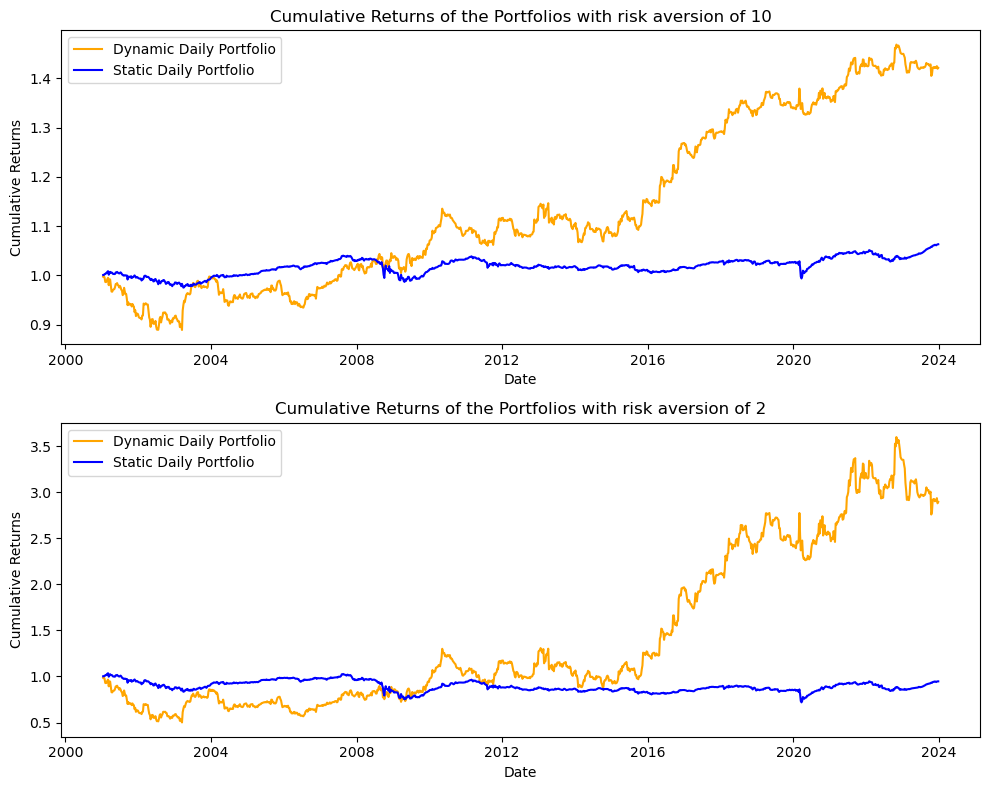

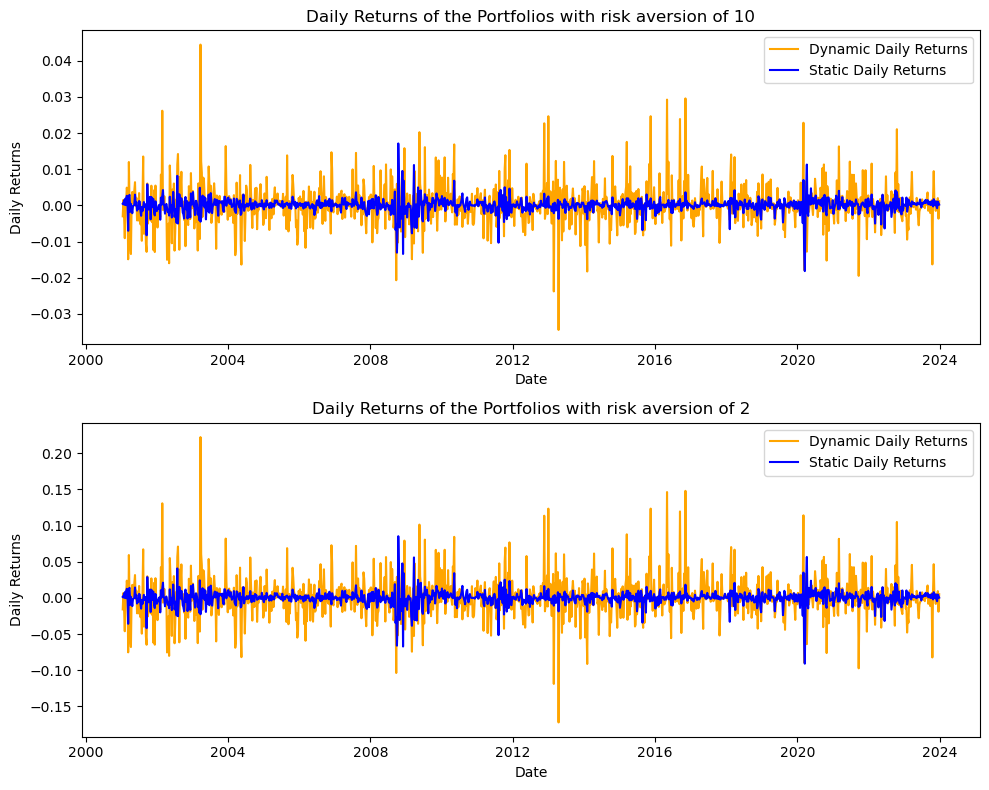

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot((1 + portfolios["Dynamic Daily Portfolio Return Risk 10"]).cumprod(), label = "Dynamic Daily Portfolio", c = 'orange')
axs[0].plot((1 + portfolios["Static Daily Portfolio Return Risk 10"]).cumprod(), label = "Static Daily Portfolio", c = 'blue')
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative Returns")
axs[0].set_title("Cumulative Returns of the Portfolios with risk aversion of 10")
axs[0].legend()

axs[1].plot((1 + portfolios["Dynamic Daily Portfolio Return Risk 2"]).cumprod(), label = "Dynamic Daily Portfolio", c = 'orange')
axs[1].plot((1 + portfolios["Static Daily Portfolio Return Risk 2"]).cumprod(), label = "Static Daily Portfolio", c = 'blue')
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Cumulative Returns")
axs[1].set_title("Cumulative Returns of the Portfolios with risk aversion of 2")
axs[1].legend()

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(portfolios["Dynamic Daily Portfolio Return Risk 10"], label = "Dynamic Daily Returns", c='orange')
axs[0].plot(portfolios["Static Daily Portfolio Return Risk 10"], label = "Static Daily Returns", c='blue')
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Daily Returns")
axs[0].set_title("Daily Returns of the Portfolios with risk aversion of 10")
axs[0].legend()

axs[1].plot(portfolios["Dynamic Daily Portfolio Return Risk 2"], label = "Dynamic Daily Returns", c='orange')
axs[1].plot(portfolios["Static Daily Portfolio Return Risk 2"], label = "Static Daily Returns", c='blue')
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Daily Returns")
axs[1].set_title("Daily Returns of the Portfolios with risk aversion of 2")
axs[1].legend()

plt.tight_layout()
plt.show()


In [41]:
loss = pd.DataFrame(index=portfolios.index)
loss["Loss of Dynamic Portfolio with Risk 10"] = -portfolios["Dynamic Daily Portfolio Return Risk 10"]
loss["Loss of Dynamic Portfolio with Risk 2"] = -portfolios["Dynamic Daily Portfolio Return Risk 2"]
loss["Loss of Static Portfolio with Risk 10"] = -portfolios["Static Daily Portfolio Return Risk 10"]
loss["Loss of Static Portfolio with Risk 2"] = -portfolios["Static Daily Portfolio Return Risk 2"]
display(loss)

,Loss of Dynamic Portfolio with Risk 10,Loss of Dynamic Portfolio with Risk 2,Loss of Static Portfolio with Risk 10,Loss of Static Portfolio with Risk 2
Date,,,,
2001-01-15,0.003004,0.015947,-0.000460,-0.001376
2001-01-22,-0.001544,-0.006798,-0.000300,-0.000582
2001-01-29,0.003011,0.015987,-0.001442,-0.006273
2001-02-05,0.009057,0.046133,-0.000180,-0.000050
2001-02-12,0.000417,0.002931,-0.001916,-0.008736
...,...,...,...,...
2023-11-27,-0.001111,-0.004725,0.000235,0.002004
2023-12-04,0.000298,0.002322,0.000759,0.004625
2023-12-11,-0.002035,-0.009344,-0.001088,-0.004611


In [77]:
exp_var = {}
for element in loss.columns:
    exp_var[element] = {
        "Unconditional Mean" : loss[element].mean(),
        "Variance" : loss[element].var()
    }

stats_df = pd.DataFrame(exp_var).T
z_value = scipy.stats.norm.ppf(0.99)
stats_df["Quantile at 99%"] = stats_df["Unconditional Mean"] + z_value * np.sqrt(stats_df["Variance"])
stats_df["VaR at 99%"] = -stats_df["Quantile at 99%"]
display(stats_df.T)


,Loss of Dynamic Portfolio with Risk 10,Loss of Dynamic Portfolio with Risk 2,Loss of Static Portfolio with Risk 10,Loss of Static Portfolio with Risk 2
Unconditional Mean,-0.000310,-0.001288,-0.000053,-0.000005
Variance,0.000032,0.000810,0.000004,0.000102
Quantile at 99%,0.012930,0.064935,0.004635,0.023438
VaR at 99%,-0.012930,-0.064935,-0.004635,-0.023438


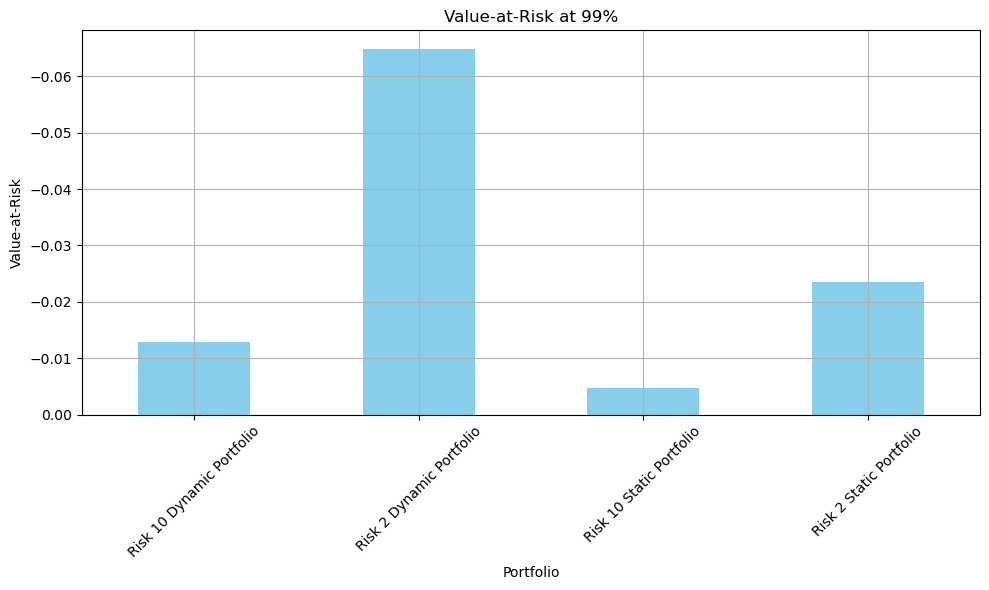

In [84]:
plt.figure(figsize=(10, 6))
stats_df['VaR at 99%'].plot(kind='bar', color='skyblue')
plt.title('Value-at-Risk at 99%')
plt.xlabel('Portfolio')
plt.ylabel('Value-at-Risk')
labels=["Risk 10 Dynamic Portfolio", "Risk 2 Dynamic Portfolio", "Risk 10 Static Portfolio", "Risk 2 Static Portfolio"]

ticks = range(4)
plt.xticks(ticks=ticks, rotation = 45, labels=labels)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid()
plt.show()


In [87]:
ar1_d10_alpha, ar1_d10_beta, ar1_d10_rsquared, ar1_d10_residuals = estimate_ar1(loss["Loss of Dynamic Portfolio with Risk 10"])
ar1_d2_alpha, ar1_d2_beta, ar1_d2_rsquared, ar1_d2_residuals = estimate_ar1(loss["Loss of Dynamic Portfolio with Risk 2"])
ar1_s10_alpha, ar1_s10_beta, ar1_s10_rsquared, ar1_s10_residuals = estimate_ar1(loss["Loss of Static Portfolio with Risk 10"])
ar1_s2_alpha, ar1_s2_beta, ar1_s2_rsquared, ar1_s2_residuals = estimate_ar1(loss["Loss of Static Portfolio with Risk 2"])

#DataFrame of AR(1) coefficients
ar1 = pd.DataFrame(index=["Risk 10 Dynamic Portfolio", "Risk 2 Dynamic Portfolio", "Risk 10 Static Portfolio", "Risk 2 Static Portfolio"])
ar1["Alpha"] = [ar1_d10_alpha, ar1_d2_alpha, ar1_s10_alpha, ar1_s2_alpha]
ar1["Beta"] = [ar1_d10_beta, ar1_d2_beta, ar1_s10_beta, ar1_s2_beta]
ar1["R-Squared"] = [ar1_d10_rsquared, ar1_d2_rsquared, ar1_s10_rsquared, ar1_s2_rsquared]
display(ar1)

,Alpha,Beta,R-Squared
Risk 10 Dynamic Portfolio,-0.000318,-0.019734,0.000390
Risk 2 Dynamic Portfolio,-0.001326,-0.018935,0.000359
Risk 10 Static Portfolio,-0.000055,-0.034797,0.001211
Risk 2 Static Portfolio,-0.000004,-0.035097,0.001232


In [92]:
garch_stats_d10, garch_stats_df_d10 = garch('D 10', ar1_d10_residuals)
garch_stats_d2, garch_stats_df_d2 = garch('D 2', ar1_d2_residuals)
garch_stats_s10, garch_stats_df_s10 = garch('S 10', ar1_s10_residuals)
garch_stats_s2, garch_stats_df_s2 = garch('S 2', ar1_s2_residuals)

display(garch_stats_s2)
print(garch_stats_df_d10)
display(garch_stats_d10)

c:\Users\salih\AppData\Local\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                4092.72
Distribution:                  Normal   AIC:                          -8179.45
Method:            Maximum Likelihood   BIC:                          -8164.18
                                        No. Observations:                 1197
Date:                Mon, May 13 2024   Df Residuals:                     1197
Time:                        20:12:05   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0142e-05  6.636e-10  1.528e+04      0.000 [1.

  GARCH(1,1) Model of :     α     β             ω  α + β
0                  D 10  0.01  0.97  6.473852e-07   0.98


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                4501.63
Distribution:                  Normal   AIC:                          -8997.26
Method:            Maximum Likelihood   BIC:                          -8981.99
                                        No. Observations:                 1197
Date:                Mon, May 13 2024   Df Residuals:                     1197
Time:                        20:12:05   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.4739e-07  3.991e-11  1.622e+04      0.000 